## Generalised Perceptron

Binary classification based on MNIST and Fashion MNIST data. 

It restricts the classification problem to two classes, selects them from the (Fashion-)MNIST dataset, splits it up into a train and test part, does normalisation and then trains a binary classification (logistic regression) to learn to differentiate between the two categories.

Both datasets consist of images with 28x28 = 784 pixel each. The features refer to these pixel values of the images.

You can choose MNIST or Fashion-MNIST data in cell [2]

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#only at first execution data is downloaded, because it is saved in subfolder ./data; 
data_set = 'FashionMNIST'
    
if data_set == 'MNIST':
    training_data = torchvision.datasets.MNIST(
        root="../data",
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )

    test_data = torchvision.datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )    

    #labels for MNIST (just for compatibility reasons)
    labels_map = {
        0: "Zero",
        1: "One",
        2: "Two",
        3: "Three",
        4: "Four",
        5: "Five",
        6: "Six",
        7: "Seven",
        8: "Eight",
        9: "Nine",
    }
else:
    training_data = torchvision.datasets.FashionMNIST(
        root="data",
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )

    test_data = torchvision.datasets.FashionMNIST(
        root="data",
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )

    #labels for FashionMNIST
    labels_map = {
        0: "T-Shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }

In [3]:
#convert to numpy array (originally it is a torch.tensor)
x = training_data.data.numpy()
x = np.append(x, test_data.data.numpy(),0)

y = training_data.targets.numpy()
y = np.append(y, test_data.targets.numpy())

print(x.shape)
print(y.shape)

(70000, 28, 28)
(70000,)


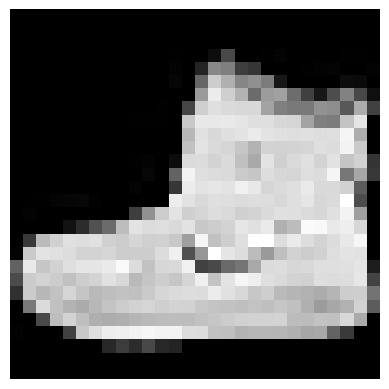

In [4]:
def plot_img(img):
    """
    plot a single mnist image
    """
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()
    
    
plot_img(x[0])

In [5]:
def plot_tiles(x_array, rows, cols = -1, fig_size = [10,10]):
    """
    plot list of images as single image

    Arguments:
    x_array -- array of images (being organised as ROWS!)
    rows/cols -- an image of rows x cols - images is created (if x_array is smaller zeros ared padded)
    fig_size -- size of full image created (default [10,10])
    """

    digit_size = 28 #size of digit (width = height)
    
    #use rows = cols as default
    if cols < 0:
        cols = rows
        
    if x_array.shape[0] < rows*cols:
        cols = int(x_array.shape[0]/rows)
        remain = np.mod(x_array.shape[0], rows)
        if 0 < remain:
            cols += 1
            x_array = np.append(x_array, np.zeros((rows-remain, x_array.shape[1])), 0)    
        
    img = x_array[0:rows,:].reshape(rows*digit_size,digit_size)
    for i0 in range(1,cols):
        #the reshape operator in the append call takes num of digit_size x digit_size images and 
        #puts them in a single column; append then does the rest
        img = np.append(img, x_array[i0*rows:(i0+1)*rows,:].reshape(rows*digit_size,digit_size),1)

    fig = plt.figure(figsize = fig_size)
    ax = fig.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()

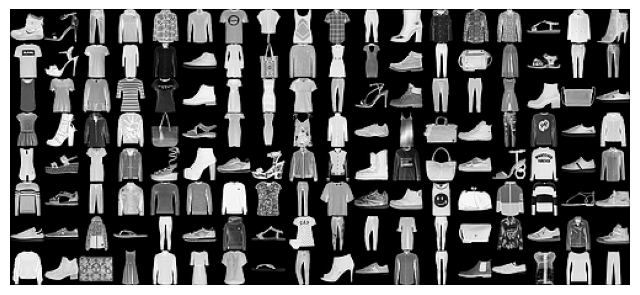

In [6]:
#append rows x cols tiles of images
rows = 8
cols = 18
#figure size can be set
fig_size = [8,8]

plot_tiles(x, rows, cols, fig_size)

Coat


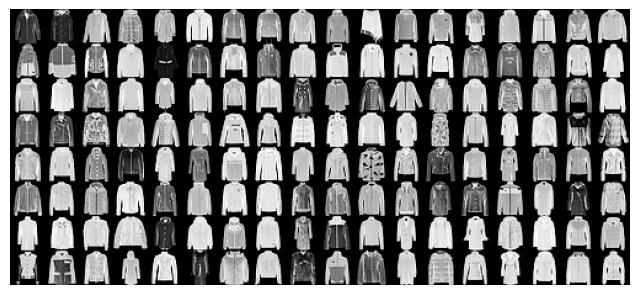

In [7]:
#choose a given class 0..9
digit  = 4

plot_tiles(x[y == digit,:], rows, cols, fig_size)
print(labels_map[digit])

In [8]:
#select the two classes for your training and test set, select train and test split and to normalization
def prepare_data(digit_1, digit_2, train_size=0.8, min_max_normalise=1, flatten=1):
    """
    prepare the data for training

    Arguments:
    digit_1 -- first digit ('True') to select
    digit_2 -- second digit ('False') to select
    train_size -- fraction of train image size
    min_max_normalise -- whether to do min-max-normalisation (1) or rescaling (0)
    flatten -- whether to flatten the 28x28 image to single row
    """
    
    #select the digit
    x_sel_1 = x[y == digit_1,:]
    x_sel_2 = x[y == digit_2,:]

    #append the x data
    x_sel = np.append(x_sel_1, x_sel_2, 0)
    #construct y-data (digit_1 is 'True')
    y_sel = np.append(np.ones((x_sel_1.shape[0],1)),
                      np.zeros((x_sel_2.shape[0],1)), 0)

    ### START YOUR CODE ###
    
    #do train and test split, also take care to randomly shuffle the data (why?)
    num_samples = x_sel.shape[0]
    max_train_ind = int(0.5*num_samples)

    #shuffle the data
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    x_sel = x_sel[indices]
    y_sel = y_sel[indices]
    
    x_train = x_sel[:max_train_ind]
    x_test = x_sel[max_train_ind:]
    
    y_train = y_sel[:max_train_ind]
    y_test = y_sel[max_train_ind:]

    ### END YOUR CODE ###     
 
    ### START YOUR CODE ###
    
    #implement min-max-normalisation and rescaling, take care of converting data type to float!  
    if min_max_normalise:
        x_train = (x_train - np.min(x_train))/(np.max(x_train) - np.min(x_train))
        x_test = (x_test - np.min(x_test))/(np.max(x_test) - np.min(x_test))
        x_train = x_train.astype(float)
        x_test = x_test.astype(float) 
    else:
        x_train = x_train/255
        x_test = x_test/255
        x_train = x_train.astype(float) 
        x_test = x_test.astype(float)

    ### END YOUR CODE ###       

    if flatten:
        m = x_train.shape[0]
        x_train = x_train.reshape([m,-1])
        m = x_test.shape[0]
        x_test = x_test.reshape([m,-1])
    
    return x_train, x_test, y_train, y_test

### Class NeuralNetwork

This class constructs a generalised perceptron. Cost function can be either MSE or CE (chosen in constructor). The method $propagate()$ returns the prediction $$ \hat{y}^{(i)}=h_\theta(\mathbf{x}^{(i)}) $$ on the input data (can be a n x 784 matrix of n images) and $back\_propagate()$ determines the gradients of the cost function with respect to the parameters (weights and bias) $$ \nabla_{\mathbf{\theta}} J(\mathbf{\theta}) $$
The method $gradient\_descend()$ finally does the correction of the parameters with a step in the negative gradient direction, weighted with the learning rate $$\alpha$$

In [9]:
class NeuralNetwork:
    """
    NN class handling the layers and doing all propagation and back-propagation steps
    """
    cost_MSE = 0
    cost_CE = 1
    
    def __init__(self, cost_function=cost_MSE, random_std = 0, size_in = 784):
        """
        constructor

        Arguments:
        cost_function -- can be cost_MSE (0, default) or cost_CE (1)
        random_std -- std for initialisation of weight (default is 0)
        size_in -- size of input image
        """
        self.size_in = size_in

        self.cost_function = cost_function
        
        #initialize weights and bias (zero or random)
        self.initialise_weights(random_std)
        
        # result array for cost and error of training and test set
        self.result_data = np.array([])
        self.result_data_dL = np.array([])
        
        #we keep a global step counter, thus that optimise can be called 
        #several times with different settings
        self.epoch_counter = 0 

        
    def initialise_weights(self, random_std):
        """
        initialize weights and bias (if random_std == 0 all weights are zero)
        """ 
        self.w = random_std*np.random.randn(self.size_in,1)
        self.b = 0
    
    
    def propagate(self, x):
        """
        predicted outcome for x
        """
        z = x @ self.w + self.b
        y_pred = self.activation_function(z)
                    
        return y_pred

    
    def activation_function(self, z):
        """
        apply activation function
        """
        ### START YOUR CODE ###

        #implement sigmoid function
        z = 1/(1 + np.exp(-z))
        
        return z
    
        ### END YOUR CODE ###   
    
    
    def back_propagate(self, x, y_pred, y):
        """
        calculates the gradients of cost function wrt w and b
        """
        #abbreviation
        m = x.shape[0]
        
        sum_w = 0
        sum_b = 0
        if self.cost_function == self.cost_MSE:
        ### START YOUR CODE ###
        

            # compute gradient with MSE cost function
            dz = y_pred * (1 - y_pred) * (y_pred - y)
            self.grad_w = np.dot(x.T, dz) / m
            self.grad_b = np.sum(dz) / m
                
        else:  
            # compute gradient with CE cost function
            dz = y_pred - y
            self.grad_w = np.dot(x.T, dz) / m
            self.grad_b = np.sum(dz) / m

            
        ### END YOUR CODE ###   
    
    
    def gradient_descend(self, alpha):
        """
        applies gradient descend step to w and b
        """
        self.w -= alpha * self.grad_w
        self.b -= alpha * self.grad_b
    
    
    def calc_error(self, y_pred, y):
        """
        get error information
        """
        m = y.shape[0]
        
        res = np.round(y_pred)        
        error = np.sum(np.abs(res - y)) / m 

        return error
    
    
    def cost_funct(self, y_pred, y):
        """
        calculates the cost function
        """
        m = y.shape[0]
        
        if self.cost_function == self.cost_MSE:
            
            ### START YOUR CODE ###

            #implement MSE cost function
            cost = 1/(2*m) * np.sum((y_pred - y)**2)

        else:

            #implement CE cost function
            cost = -1/m * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))   
            
        ### END YOUR CODE ###                     
                            
        return cost   
    
    
    def append_result(self):
        """
        append cost and error data to output array
        """
        # determine cost and error functions for train and test data
        y_pred_train = self.propagate(self.data['x_train'])
        y_pred_test = self.propagate(self.data['x_test'])

        res_data = np.array([[self.cost_funct(y_pred_train, self.data['y_train']), 
                              self.calc_error(y_pred_train, self.data['y_train']),
                              self.cost_funct(y_pred_test, self.data['y_test']), 
                              self.calc_error(y_pred_test, self.data['y_test'])]])
        
        # first call
        if self.result_data.size == 0:
            self.result_data = res_data
        else:
            self.result_data = np.append(self.result_data, res_data, 0)

        #increase epoch counter here (used for plot routines below)
        self.epoch_counter += 1 
        
        return res_data
    
    
          
    def optimise(self, data, epochs, alpha, debug=0):
        """
        performs epochs number of gradient descend steps and appends result to output array

        Arguments:
        data -- dictionary with NORMALISED data
        epochs -- number of epochs
        alpha -- learning rate
        debug -- False (default)/True; get info on gradient descend step
        """
        #access to data from other methods
        self.data = data
        
        # save results before 1st step
        if self.epoch_counter == 0:
            res_data = self.append_result()

        for i0 in range(0, epochs):            
            y_pred = self.propagate(data['x_train'])
            self.back_propagate(data['x_train'], y_pred, data['y_train'])
            self.gradient_descend(alpha)
          
            res_data = self.append_result()
                      
            if debug and np.mod(i0, debug) == 0:
                print('result after %d epochs, train: cost %.5f, error %.5f ; test: cost %.5f, error %.5f'
                                          % (self.epoch_counter-1, res_data[0, 0], res_data[0, 1], res_data[0, 2], res_data[0, 3]))

        if debug:
            print('result after %d epochs, train: cost %.5f, error %.5f ; test: cost %.5f, error %.5f'
                  % (self.epoch_counter-1, res_data[0, 0], res_data[0, 1], res_data[0, 2], res_data[0, 3]))
    

In [10]:
def plot_error(nn_instance):
    """
    analyse error as function of epochs

    Arguments:
    nn_instance -- NeuralNetwork class to plot
    """
    epochs = np.arange(nn_instance.epoch_counter)
    train_error = nn_instance.result_data[:,1]
    val_error = nn_instance.result_data[:,3]

    plt.semilogy(epochs, train_error, label="train")
    plt.semilogy(epochs, val_error, label="test")
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    xmax = epochs[-1]
    ymin = 5e-4
    ymax = 5e-1
    plt.axis([0,xmax,ymin,ymax])
    plt.legend()
    plt.show() 

In [11]:
def plot_cost(nn_instance):
    """
    analyse cost as function of epochs

    Arguments:
    nn_instance -- NeuralNetwork class to plot
    """
    epochs = np.arange(nn_instance.epoch_counter)
    train_costs = nn_instance.result_data[:,0]
    val_costs = nn_instance.result_data[:,2]

    plt.semilogy(epochs, train_costs, label="train")
    plt.semilogy(epochs, val_costs, label="test")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    xmax = epochs[-1]
    ymin = 5e-3
    ymax = 2
    plt.axis([0,xmax,ymin,ymax])

    plt.legend()
    plt.show() 

### Sample execution of Neural Network

The cell below shows how to use the class NeuralNetwork and how to perform the optimisation. The training and test data is given as dictionary in the call to the method $optimise()$. This method can be called several times in a row with different arguments.

result after 1 epochs, train: cost 0.14521, error 0.46314 ; test: cost 0.14661, error 0.46714
result after 101 epochs, train: cost 0.02001, error 0.04857 ; test: cost 0.01984, error 0.04786
result after 201 epochs, train: cost 0.01794, error 0.04329 ; test: cost 0.01790, error 0.04271
result after 301 epochs, train: cost 0.01695, error 0.04029 ; test: cost 0.01701, error 0.04014
result after 401 epochs, train: cost 0.01630, error 0.03814 ; test: cost 0.01644, error 0.03914
result after 501 epochs, train: cost 0.01582, error 0.03714 ; test: cost 0.01603, error 0.03757
result after 601 epochs, train: cost 0.01543, error 0.03657 ; test: cost 0.01571, error 0.03671
result after 701 epochs, train: cost 0.01511, error 0.03557 ; test: cost 0.01546, error 0.03543
result after 800 epochs, train: cost 0.01484, error 0.03543 ; test: cost 0.01526, error 0.03529


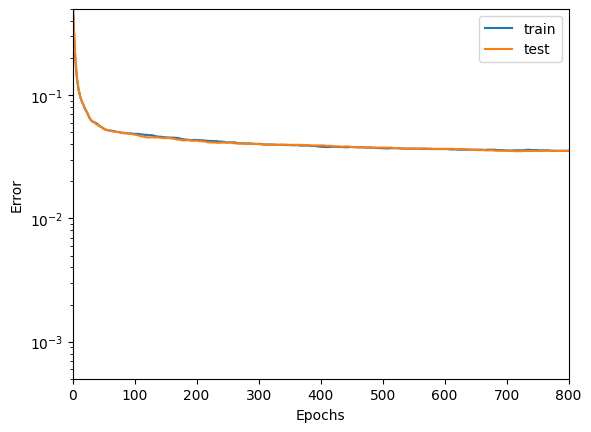

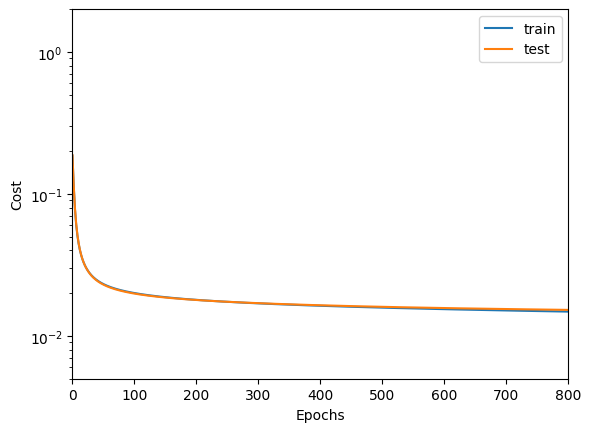

In [12]:
x_train, x_test, y_train, y_test = prepare_data(0, 2, train_size=0.8, min_max_normalise=0, flatten=1)

data = {'x_train' : x_train, 'y_train' : y_train, 'x_test' : x_test, 'y_test' : y_test}


NNet_MSE = NeuralNetwork(cost_function=0, random_std = 0.2, size_in = 784)

NNet_MSE.optimise(data, 800, 0.5, debug=100)

plot_error(NNet_MSE)
plot_cost(NNet_MSE)

result after 1 epochs, train: cost 1.08862, error 0.66314 ; test: cost 1.09116, error 0.66071
result after 101 epochs, train: cost 0.16226, error 0.05314 ; test: cost 0.16007, error 0.05014
result after 201 epochs, train: cost 0.14380, error 0.04629 ; test: cost 0.14317, error 0.04600
result after 301 epochs, train: cost 0.13596, error 0.04357 ; test: cost 0.13633, error 0.04443
result after 401 epochs, train: cost 0.13114, error 0.04157 ; test: cost 0.13226, error 0.04300
result after 501 epochs, train: cost 0.12767, error 0.04043 ; test: cost 0.12940, error 0.04143
result after 601 epochs, train: cost 0.12497, error 0.03914 ; test: cost 0.12723, error 0.04043
result after 701 epochs, train: cost 0.12276, error 0.03829 ; test: cost 0.12548, error 0.04000
result after 801 epochs, train: cost 0.12088, error 0.03771 ; test: cost 0.12404, error 0.03943
result after 901 epochs, train: cost 0.11926, error 0.03714 ; test: cost 0.12283, error 0.03914
result after 1001 epochs, train: cost 0.11

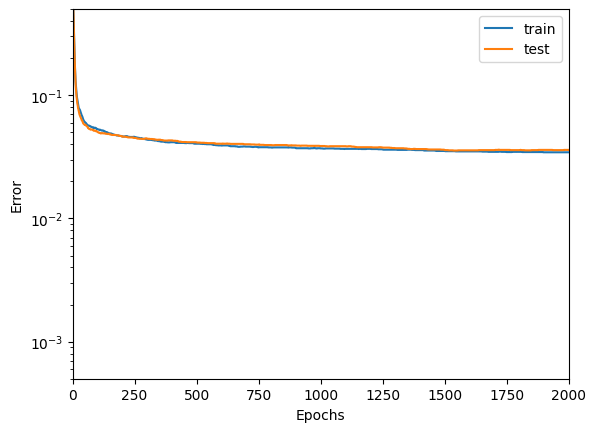

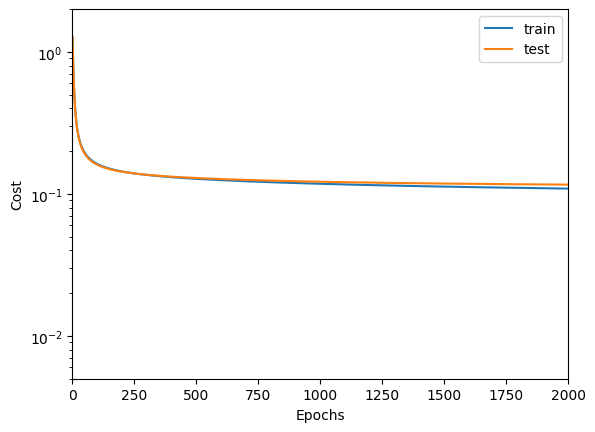

In [13]:
NNet_CE = NeuralNetwork(cost_function=1, random_std = 0.2, size_in = 784)

NNet_CE.optimise(data, 2000, 0.05, debug=100)

plot_error(NNet_CE)
plot_cost(NNet_CE)

In [14]:
def summary_of_results(nn_instance, data):
    """
    Compute confusion matrix and return values as percentages.
    
    Arguments:
    nn_instance -- NeuralNetwork class instance to use for prediction
    data -- dictionary with NORMALISED data ('x_test' for inputs and 'y_test' for actual outputs)
    """
    y_pred = nn_instance.propagate(data['x_test'])
    y_pred = np.round(y_pred).flatten()  
    y = data['y_test'].flatten()  
    
    cm = np.zeros((2,2))
    cm[0,0] = np.sum((y_pred == 1) & (y == 1))
    cm[0,1] = np.sum((y_pred == 1) & (y == 0))
    cm[1,0] = np.sum((y_pred == 0) & (y == 1))
    cm[1,1] = np.sum((y_pred == 0) & (y == 0))
    
    total_predictions = np.sum(cm)
    cm_percentage = (cm / total_predictions) * 100  # Convert counts to percentages
    
    return cm_percentage


results = summary_of_results(NNet_MSE, data)
print("Results for instance using MSE: ", results)

results = summary_of_results(NNet_CE, data)
print("Results for instance using CE: ", results)


Results for instance using MSE:  [[47.84285714  1.31428571]
 [ 2.21428571 48.62857143]]
Results for instance using CE:  [[47.92857143  1.47142857]
 [ 2.12857143 48.47142857]]


In [15]:
# Create an empty list to store the final error rates
final_error_rates = []

# Perform 10 successive training runs
for _ in range(10):
    NNet_MSE = NeuralNetwork(cost_function=0, random_std=0.2, size_in=784)
    NNet_MSE.optimise(data, 800, 0.5)
    final_error_rates.append(NNet_MSE.result_data[-1, 1])  # Append the final error rate to the list

# Calculate the average and standard deviation of the final error rates
average_error_rate = np.mean(final_error_rates)
std_dev_error_rate = np.std(final_error_rates)

print("Average error rate: ", average_error_rate)
print("Standard deviation of error rates: ", std_dev_error_rate)
print("Final error rates: ", final_error_rates)


Average error rate:  0.035957142857142854
Standard deviation of error rates:  0.0009753073822113309
Final error rates:  [0.037714285714285714, 0.03471428571428571, 0.03542857142857143, 0.036571428571428574, 0.03571428571428571, 0.03571428571428571, 0.03542857142857143, 0.03757142857142857, 0.03485714285714286, 0.03585714285714286]


(250, 784)


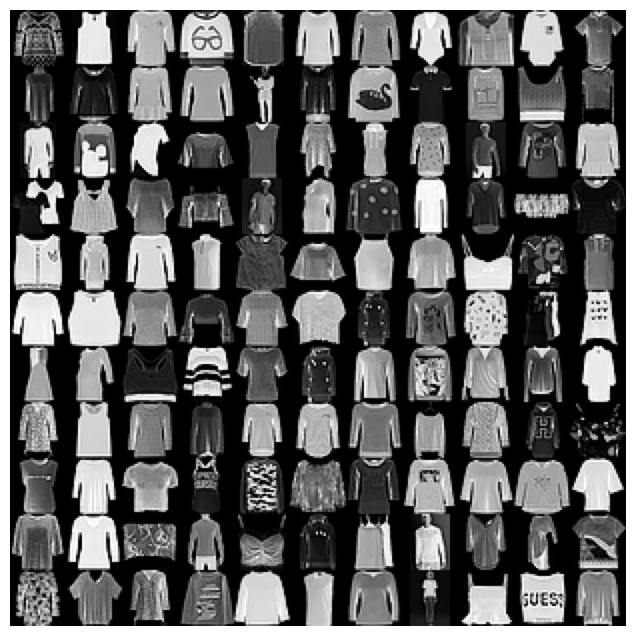

In [17]:
#analyse false classified training or test images
y_pred = np.round(NNet_MSE.propagate(data['x_test']))
false_classifications = data['x_test'][(y_pred != data['y_test'])[:,0]]

print(false_classifications.shape)

#append rows x cols tiles of digits
rows = 11
cols = 11
#figure size can be set
fig_size = [8,8]

plot_tiles(false_classifications, rows, cols, fig_size)